In [5]:
import sys
import os
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), "..")))

In [6]:
import numpy as np
from utility import get_random_matrices_any_size, get_random_matrix_pair_any_size, pad_matrix_even, unpad_matrix
from matrix_mult import binet, strassen, ai_matrix_mult
import time
import matplotlib.pyplot as plt

Klasa dziedzicząca po float i przładowująca operacje zmiennoprzecinkowe, dodając licznik przy ich każdorazowym wywołaniu.

In [36]:
class FloatCounter(float):  

    mul_counter = 0
    add_counter = 0
    sub_counter = 0
    div_counter = 0

    def __new__(cls, value):
        return super().__new__(cls, value)

    def __mul__(self, other):
        FloatCounter.mul_counter += 1
        return FloatCounter(super().__mul__(other))

    def __rmul__(self, value):
        FloatCounter.mul_counter += 1
        return FloatCounter(super().__rmul__(value))

    def __add__(self, value):
        FloatCounter.add_counter += 1
        return FloatCounter(super().__add__(value))

    def __radd__(self, value):
        FloatCounter.add_counter += 1
        return FloatCounter(super().__radd__(value))

    def __sub__(self, value):
        FloatCounter.sub_counter += 1
        return FloatCounter(super().__sub__(value))

    def __rsub__(self, value):
        FloatCounter.sub_counter += 1
        return FloatCounter(super().__rsub__(value))
    
    def reset_counters():
        FloatCounter.mul_counter = 0
        FloatCounter.add_counter = 0
        FloatCounter.sub_counter = 0
        FloatCounter.div_counter = 0

    def descriptive_print():
        print(f'''Multiplications: {FloatCounter.mul_counter},\nAdditions: {FloatCounter.add_counter},\nSubtractions: {FloatCounter.sub_counter}\n''')

    def get_data():
        return (FloatCounter.mul_counter, FloatCounter.add_counter, FloatCounter.sub_counter, FloatCounter.div_counter)

Rzutowanie macierzy float'ów na macierz FloatCounter'ów (np.array(A, dtype=FloatCounter) nie działa)

In [37]:
def float_matrix_to_floatcounter_matrix(a):
    b = np.zeros(a.shape, dtype=FloatCounter)
    for i in range(len(a)):
        for j in range(len(a[i])):
            b[i][j] = FloatCounter(a[i][j])
    return b

Test zliczania FLOPS'ów dla algorytmu Binet'a

In [38]:
A, B = get_random_matrix_pair_any_size(2) # 2 x 2
A = float_matrix_to_floatcounter_matrix(A)
B = float_matrix_to_floatcounter_matrix(B)
FloatCounter.reset_counters()
binet(A, B)
FloatCounter.descriptive_print()
FloatCounter.reset_counters()

Multiplications: 8,
Additions: 4,
Subtractions: 0



Test zliczania FLOPS'ów dla algorytmu Strassen'a

In [39]:
A, B = get_random_matrix_pair_any_size(2) # 2 x 2
A = float_matrix_to_floatcounter_matrix(A)
B = float_matrix_to_floatcounter_matrix(B)
FloatCounter.reset_counters()
strassen(A, B)
FloatCounter.descriptive_print()
FloatCounter.reset_counters()

Multiplications: 7,
Additions: 12,
Subtractions: 6



Funkcja mierząca liczbę FLOPS'ów dla danego algorytmu

In [41]:
def measure_FLOPS_and_runtime(function, ns, filename):
    # Clearing the file
    with open(filename, "w") as file:
        pass

    for i in ns:

        A, B = get_random_matrix_pair_any_size(i)

        A = float_matrix_to_floatcounter_matrix(A)
        B = float_matrix_to_floatcounter_matrix(B)

        FloatCounter.reset_counters()

        start = time.time()

        function(A, B)

        end = time.time()

        results = FloatCounter.get_data()

        with open(filename, "a") as file:
            file.write(str(i) + " " + str(results[0]) + " " + str(results[1]) + " " + str(results[2]) + " " + str(end-start) + "\n")

Funckaj wyświetlająca wykres dla zmierzonej liczby FLOPS'óœ

In [42]:
def show_FLOPS_plot(filename, algorithm_name):
    data = np.loadtxt(filename)

    n = data[:, 0]
    mul = data[:, 1]
    add = data[:, 2]
    sub = data[:, 3]

    flops = mul + add + sub

    plt.figure(figsize=(10, 6))
    plt.plot(flops, label=algorithm_name)
    
    plt.legend()

    plt.xlabel("Rozmiar macierzy")
    plt.ylabel("Liczba FLOPS'ów")
    plt.title(f"Porównanie liczby FLOPS'ów do rozmiarów macierzy")

    plt.show()

Funckja porównująca liczby FLOPS'ów

In [31]:
def show_mult_comparison_plot(filename1, filename2, algorithm_name_1, algorithm_name_2):
    data1 = np.loadtxt(filename1)

    n1 = data1[:, 0]
    mul1 = data1[:, 1]

    data2 = np.loadtxt(filename2)

    mul2 = data2[:, 1]

    flops1 = mul1
    flops2 = mul2

    plt.figure(figsize=(10, 6))
    plt.step(n1, flops1, label=algorithm_name_1)
    plt.step(n1, flops2, label=algorithm_name_2)

    plt.legend()

    plt.xlabel("Rozmiar macierzy")
    plt.ylabel("Liczba mnożeń")
    plt.title(f"Porównanie liczby mnożeń do rozmiarów macierzy")

    plt.show()

Zliczanie FLOPS'ów dla algorytmu Binet'a

In [ ]:
measure_FLOPS_and_runtime(binet, range(1, 1000), "Data/binet_flops_runtime.txt")

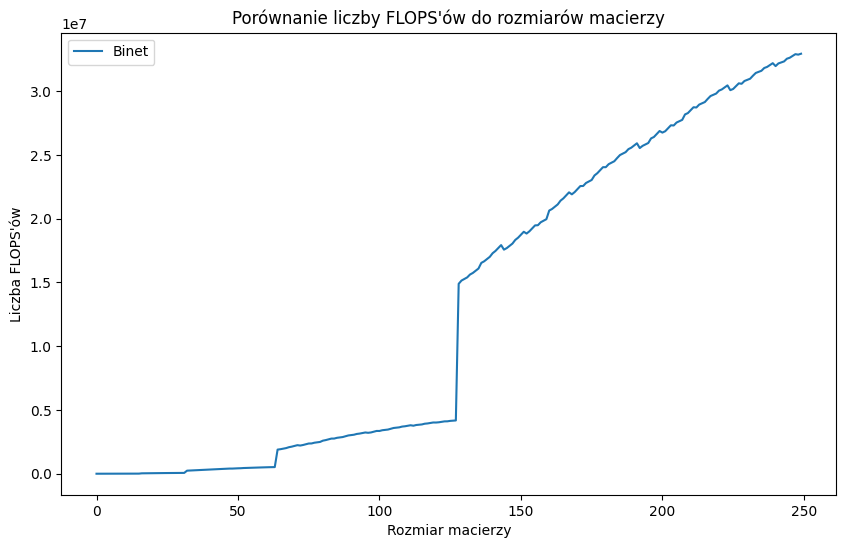

In [29]:
show_FLOPS_plot("Data/binet_flops_runtime.txt", "Binet")

Zliczanie liczby FLOPS'ów dla algorytmu Strassena

In [ ]:
measure_FLOPS_and_runtime(strassen, range(1, 1000), "Data/strassen_flops_runtime.txt")

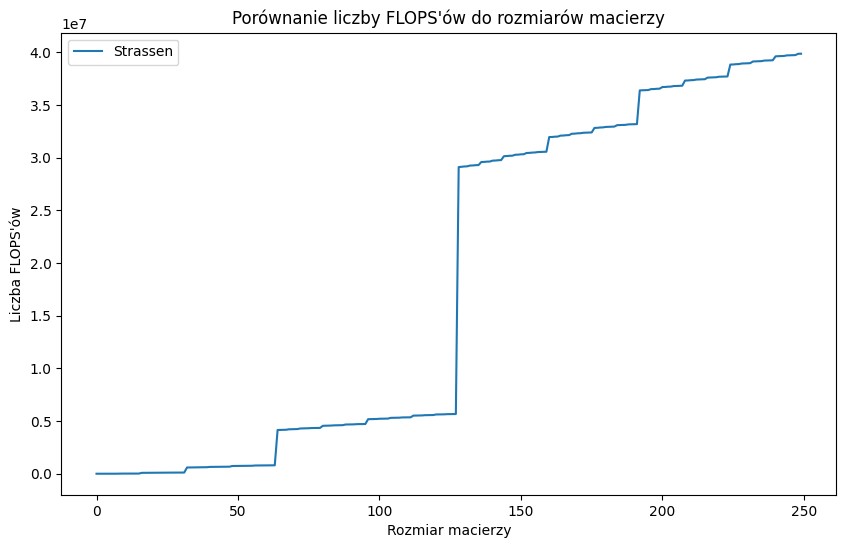

In [45]:
show_FLOPS_plot("Data/strassen_flops_runtime.txt", "Strassen")

Porównanie liczby FLOPS'ów między Binetem, a Strassenem

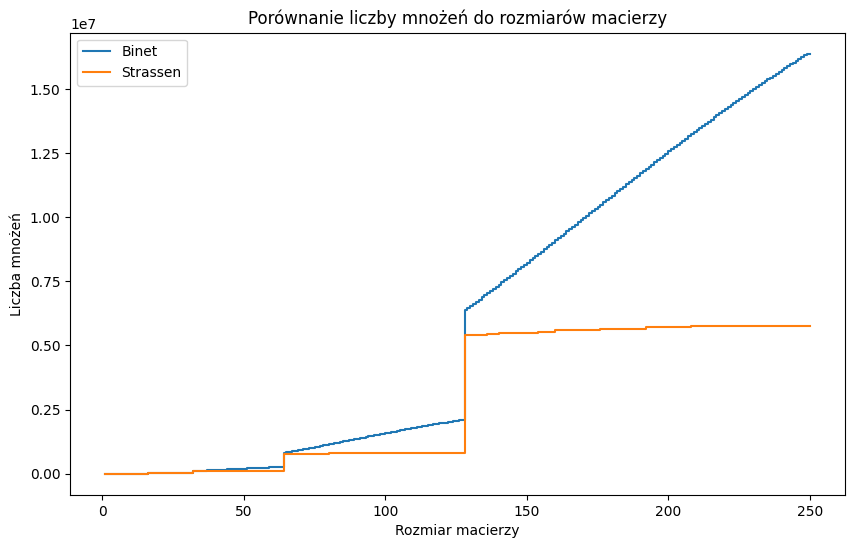

In [32]:
show_mult_comparison_plot("Data/binet_flops_runtime.txt", "Data/strassen_flops_runtime.txt", "Binet", "Strassen")

Funkcja mierząca czasy wykonania dla danego algorytmu

Funkcja rysująca wykres czasów wykonania

In [7]:
def show_runtime_plot(filename, algorithm_name):
    data = np.loadtxt(filename)
    
    n = data[:, 0]
    runtime = data[:, 5]

    plt.figure(figsize=(10, 6))
    plt.plot(n, runtime, label=f"{algorithm_name} Runtime", color='blue', marker='o')

    plt.xlabel("Rozmiar macierzy")
    plt.ylabel("Czas wykonania")
    plt.title(f"Porównanie czasów wykonania do rozmiarów macierzy dla algorytmu {algorithm_name}")
    plt.legend()

    plt.show()

In [25]:
def fit_curve_to_runtime_plot(filename, algorithm_name, curve_function, function_name):
    data = np.loadtxt(filename)
    
    n = data[:, 0]
    runtime = data[:, 5]

    plt.figure(figsize=(10, 6))


    n_function = np.array(list(map(curve_function, n)))
    scaling_factor = np.mean(runtime / n_function)
    scaled_n_function = n_function * scaling_factor

        
    plt.plot(n, scaled_n_function, label=function_name, color='red')
        
    plt.plot(n, runtime, label=f"{algorithm_name} Runtime", color='blue', marker='o')

    plt.xlabel("Rozmiar macierzy")
    plt.ylabel("Czas wykonania")
    plt.title(f"Porównanie czasów wykonania do rozmiarów macierzy dla algorytmu {algorithm_name}")
    plt.legend()

    plt.show()


Funkcja porównująca czasy wykonania

In [15]:
def show_runtime_comparison_plot(filename1, filename2, algorithm_name1, algorithm_name2):
    data1 = np.loadtxt(filename1)

    n1 = data1[:, 0]
    runtime1 = data1[:, 5]

    data2 = np.loadtxt(filename2)
    n2 = data2[:, 0]
    runtime2 = data2[:, 5]

    plt.figure(figsize=(10, 6))
    plt.plot(n1, runtime1, label = algorithm_name1)
    plt.plot(n2, runtime2, label = algorithm_name2)

    plt.legend()

    plt.xlabel("Rozmiar macierzy")
    plt.ylabel("Czas wykonania")
    plt.title(f"Porównanie czasów wykonania do rozmiarów macierzy")

    plt.show()

Mierzenie czasów wykonania dla algorytmu Bineta

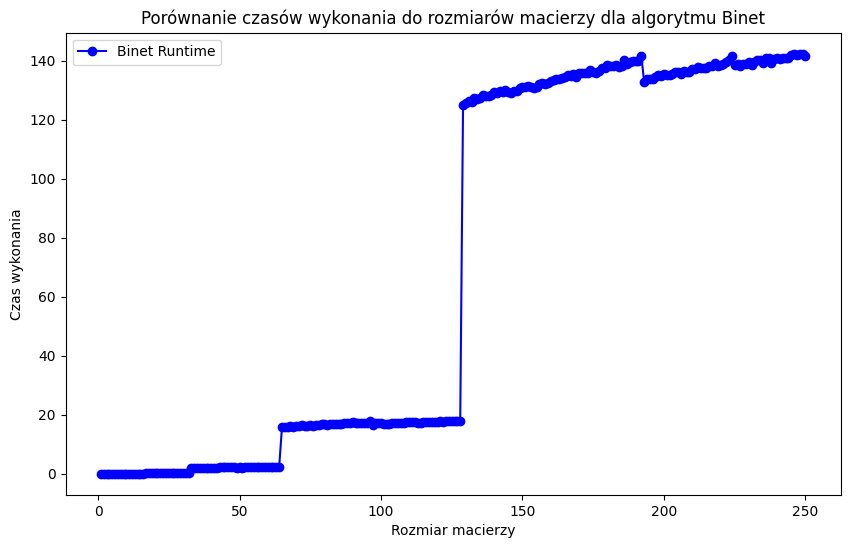

In [20]:
show_runtime_plot("Data/binet_flops_runtime.txt", "Binet")

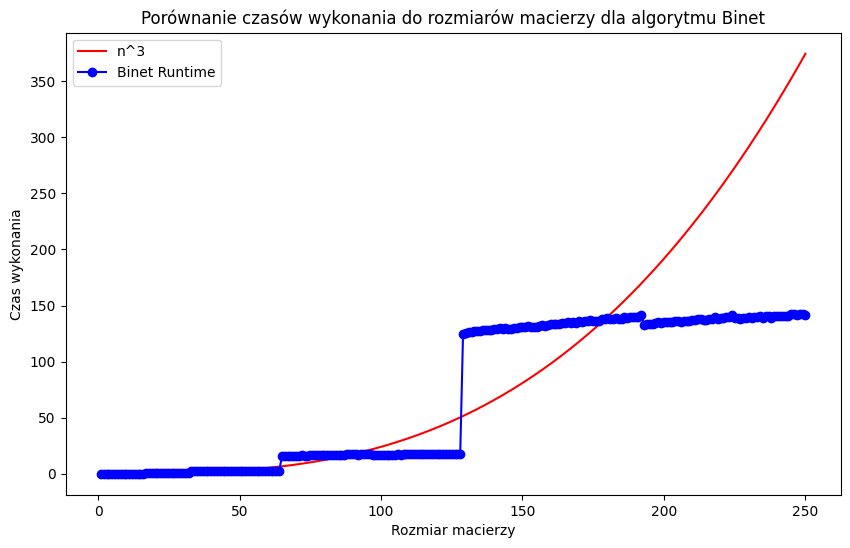

In [26]:
fit_curve_to_runtime_plot("Data/binet_flops_runtime.txt", "Binet", lambda x : x**3, 'n^3')

Mierzenie czasów wykonania dla algorytmu Strassena

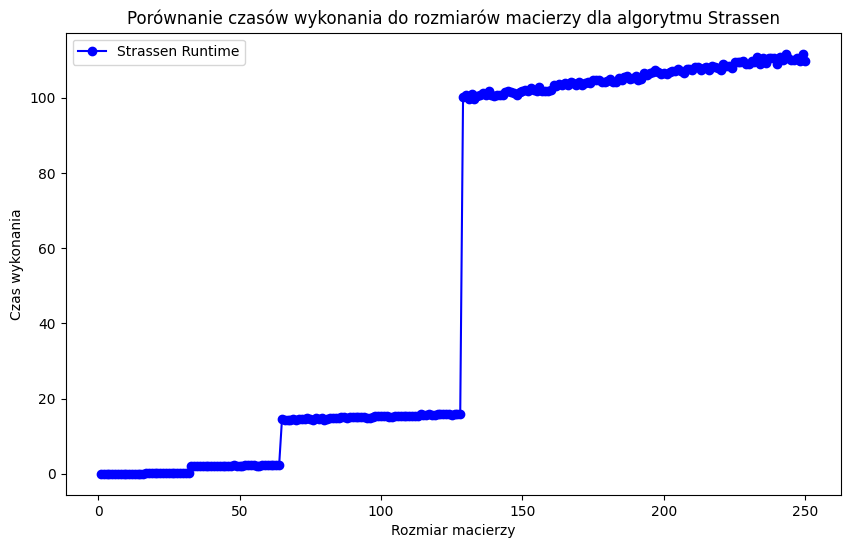

In [12]:
show_runtime_plot("Data/strassen_flops_runtime.txt", "Strassen")

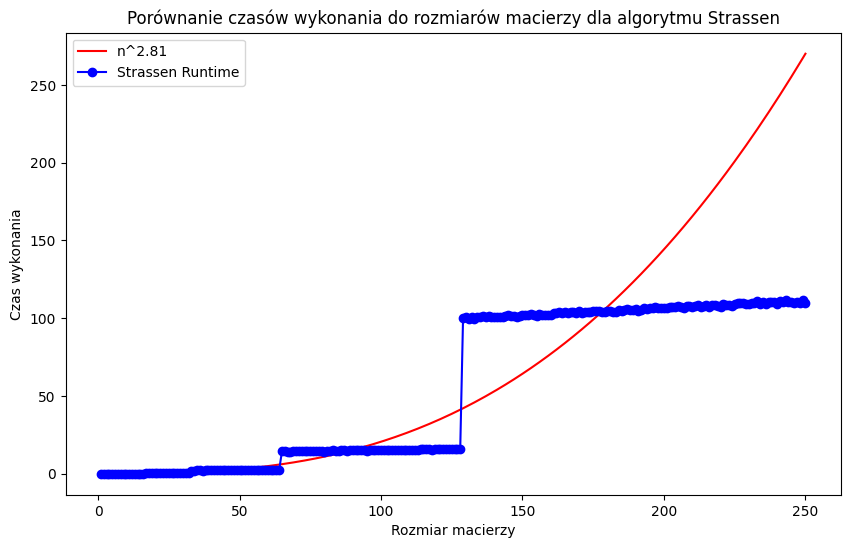

In [27]:
fit_curve_to_runtime_plot("Data/strassen_flops_runtime.txt", "Strassen", lambda x : x**2.81, 'n^2.81')

Porównanie czasów wykonania dla obu algorytmów

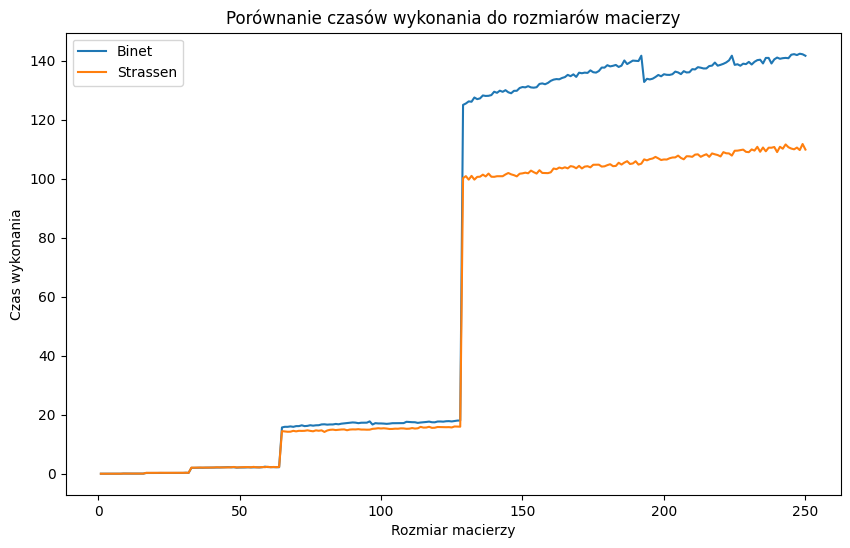

In [16]:
show_runtime_comparison_plot("Data/binet_flops_runtime.txt", "Data/strassen_flops_runtime.txt", "Binet", "Strassen")

Porównanie z wynikami z Octave.

In [31]:
# Macierze wykorzystane w Octave
A = np.array([[1.1, 2.2, 3.3, 7.1],
     [4.4, 5.5, 6.6, 3.2],
     [7.7, 8.8, 9.9, 5.1]])

B = np.array([[9.9, 8.8, 7.7, 7.6],
     [6.6, 5.5, 4.4, 6.2],
     [3.3, 2.2, 1.1, 1.2]])

C_1 = binet(A, B)
C_2 = strassen(A, B)

print("Binet:")
print(C_1)
print("Strassen:")
print(C_2)

Binet:
[[ 36.3   29.04  21.78  25.96]
 [101.64  83.49  65.34  75.46]
 [166.98 137.94 108.9  124.96]]
Strassen:
[[ 36.3   29.04  21.78  25.96]
 [101.64  83.49  65.34  75.46]
 [166.98 137.94 108.9  124.96]]


Test mnożenia metodą AI

In [32]:
A = np.array([
    [0.12, 0.34, 0.56, 0.78, 4.55],
    [1.23, 1.45, 1.67, 1.89, 4.66],
    [2.01, 2.23, 2.45, 2.67, 4.77],
    [3.11, 3.22, 3.33, 3.44, 4.88]
])

B = np.array([
    [0.10, 0.20, 0.30, 0.40, 0.50],
    [1.00, 1.10, 1.20, 1.30, 1.40],
    [2.00, 2.10, 2.20, 2.30, 2.40],
    [3.00, 3.10, 3.20, 3.30, 3.40],
    [4.00, 4.10, 4.20, 4.30, 4.40]
])

ai_start = time.time()
C_1 = ai_matrix_mult(A, B)
ai_stop = time.time()

C_2 = np.dot(A, B)

print(C_1)

print(C_2)

print("Czas wykonania: ",ai_stop - ai_start, "\nBłąd: ", np.absolute(np.array(C_1) - np.array(C_2)))



[[22.012 22.647 23.282 23.917 24.552]
 [29.223 30.313 31.403 32.493 33.583]
 [34.421 35.834 37.247 38.66  40.073]
 [40.031 41.829 43.627 45.425 47.223]]
[[22.012 22.647 23.282 23.917 24.552]
 [29.223 30.313 31.403 32.493 33.583]
 [34.421 35.834 37.247 38.66  40.073]
 [40.031 41.829 43.627 45.425 47.223]]
Czas wykonania:  0.0 
Błąd:  [[3.55271368e-15 0.00000000e+00 3.55271368e-15 7.10542736e-15
  3.55271368e-15]
 [3.55271368e-15 3.55271368e-15 1.06581410e-14 7.10542736e-15
  7.10542736e-15]
 [0.00000000e+00 0.00000000e+00 1.42108547e-14 0.00000000e+00
  0.00000000e+00]
 [0.00000000e+00 2.13162821e-14 0.00000000e+00 0.00000000e+00
  1.42108547e-14]]
